
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

#### Importação de bibliotecas

In [42]:
# Bibliotecas básicas
import pandas as pd
import numpy as np
import re

# Bibliotecas para preparação dos dados
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from unidecode import unidecode

# Bibliotecas para exibição de gráficos
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sbn

# Bibliotecas relacionadas à arquitetura da rede neural
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, Flatten
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [14]:
GLOVE_EMBEDDINGS = {}

In [15]:
# Carregando os vetores GloVe
glove_file = '../embeddings/glove.6B.50d.txt'

In [16]:
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        
        # Tratando a substituição da vírgula por ponto no vetor de embedding
        if ',' in values[1]:
            embedding = [float(val.replace(',', '.')) for val in values[1:]]
        
        GLOVE_EMBEDDINGS[word] = embedding
print('Achados %s vetores de palavras' % len(GLOVE_EMBEDDINGS))

Achados 400000 vetores de palavras


In [17]:
# Carregando dataset pre-processado
df = pd.read_csv('../datasets/buscape_processed.csv')

In [18]:
# Balanceado dataset
from imblearn.over_sampling import RandomOverSampler

In [19]:
# Criando uma instância do RandomOverSampler
ros = RandomOverSampler()

In [20]:
# Alterarando o shape dos dados para uma representação com uma única coluna
# Os dados foram mantidos, mas agora X possui uma coluna adicional, tornando-se uma matriz bidimensional em vez de uma matriz unidimensional
X = np.array(df['review_text'])
X = X.reshape(-1, 1)

In [21]:
y = df['rating']

In [22]:
# Aplicando o RandomOverSampler para gerar novas amostras
X_res, y_res = ros.fit_resample(X, y)

In [23]:
# Verificando dataset após balanceamento
print(pd.Series(y_res).value_counts())

rating
1    66816
0    66816
Name: count, dtype: int64


In [24]:
# definindo corpus
CORPUS = df['review_text']

In [25]:
CORPUS = [str(text) for text in CORPUS]

In [26]:
MAX_WORDS = 16000

In [27]:
tokenizer = Tokenizer(num_words=MAX_WORDS)

In [28]:
tokenizer.fit_on_texts(CORPUS)

In [29]:
WORD_INDEX = tokenizer.word_index

In [30]:
print(f'Quantindade de palavras: {MAX_WORDS}')

Quantindade de palavras: 16000


In [31]:
SEQUENCES = tokenizer.texts_to_sequences(CORPUS)

In [32]:
X = pad_sequences(SEQUENCES, truncating='post', padding='post')

In [33]:
INPUT_LENGTH = len(X[0])

In [34]:
print(f'Dimensão de embeddings dos vetores do corpus: {INPUT_LENGTH}')

Dimensão de embeddings dos vetores do corpus: 808


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [646]:
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

X_train: (58900, 808)
y_train: (58900,)
X_test: (14726, 808)
y_test: (14726,)


In [36]:
# Dimensão do embedding do glove
EMBED_DIM = 50

In [37]:
EMBEDDING_MATRIX = np.zeros((MAX_WORDS, EMBED_DIM))
print(EMBEDDING_MATRIX.shape)

(16000, 50)


In [38]:
# Montando matriz de pesos do glove
for word, index in WORD_INDEX.items():
    if index > MAX_WORDS-1:
        continue
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDING_MATRIX[index] = embedding_vector

In [39]:
EMBEDDING_MATRIX.shape

(16000, 50)

In [40]:
model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS,output_dim=EMBED_DIM, input_length=INPUT_LENGTH, weights=[EMBEDDING_MATRIX]))
model.add(Flatten())
model.add(Dense(24, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 808, 50)           800000    
                                                                 
 flatten (Flatten)           (None, 40400)             0         
                                                                 
 dense (Dense)               (None, 24)                969624    
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,769,649
Trainable params: 1,769,649
Non-trainable params: 0
_________________________________________________________________


In [43]:
LEARNING_RATE = 5e-4
LOSS = 'binary_crossentropy'
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
METRICS = ['acc']
BATCH_SIZE = 32
EPOCHS = 10
CHECKPOINT = ModelCheckpoint(filepath='../weights/glove_tl_weights.hdf5', verbose=1, save_best_only=True)
EARLY_STOP = EarlyStopping(monitor='val_loss', patience=3)
CALLBACKS = [CHECKPOINT, EARLY_STOP]

In [44]:
# Compilando o modelo
model.compile(
    loss=LOSS,
    optimizer=OPTIMIZER, 
    metrics=METRICS
)

In [45]:
model_history = model.fit(
    X_train, 
    y_train, 
    verbose=1, 
    batch_size=BATCH_SIZE,  
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=CALLBACKS
)

Epoch 1/10
1841/1841 [==============================] - ETA: 0s - loss: 0.2431 - acc: 0.9163
Epoch 1: val_loss improved from inf to 0.19219, saving model to ../weights/glove_tl_weights.hdf5
1841/1841 [==============================] - 40s 22ms/step - loss: 0.2431 - acc: 0.9163 - val_loss: 0.1922 - val_acc: 0.9326
Epoch 2/10
1840/1841 [============================>.] - ETA: 0s - loss: 0.1660 - acc: 0.9451
Epoch 2: val_loss improved from 0.19219 to 0.17669, saving model to ../weights/glove_tl_weights.hdf5
1841/1841 [==============================] - 42s 23ms/step - loss: 0.1661 - acc: 0.9450 - val_loss: 0.1767 - val_acc: 0.9415
Epoch 3/10
1840/1841 [============================>.] - ETA: 0s - loss: 0.1320 - acc: 0.9575
Epoch 3: val_loss did not improve from 0.17669
1841/1841 [==============================] - 43s 24ms/step - loss: 0.1320 - acc: 0.9575 - val_loss: 0.1788 - val_acc: 0.9437
Epoch 4/10
1840/1841 [============================>.] - ETA: 0s - loss: 0.1075 - acc: 0.9666
Epoch 4:

In [47]:
NB_START_EPOCHS = 5

In [48]:
def eval_metric(history, metric_name):
    '''
    Função para avaliar o modelo treinado na métrica escolhida. 
    Treino e valição são plotados por época.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

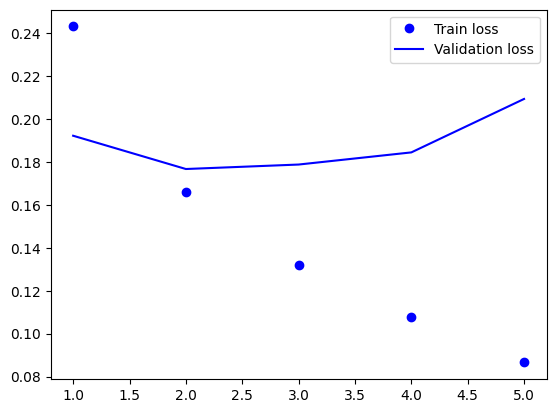

In [49]:
eval_metric(model_history, 'loss')

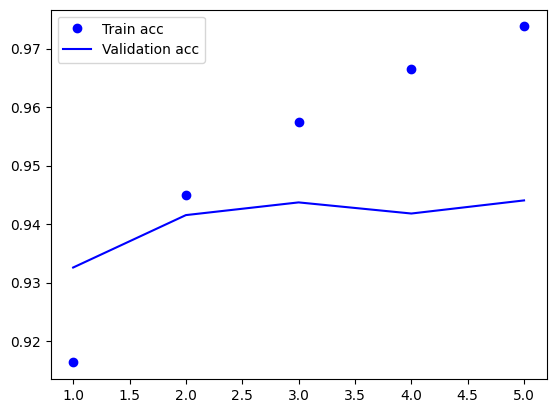

In [50]:
eval_metric(model_history, 'acc')

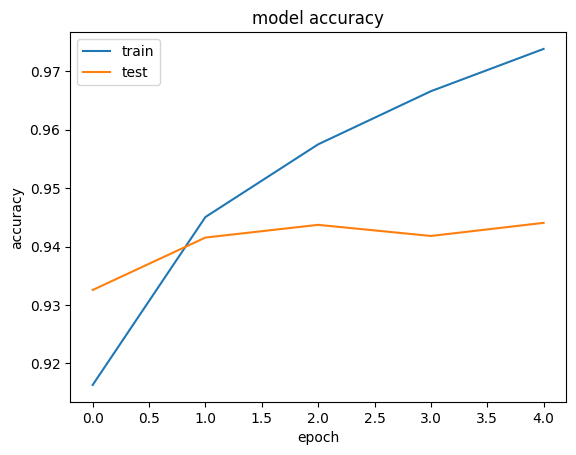

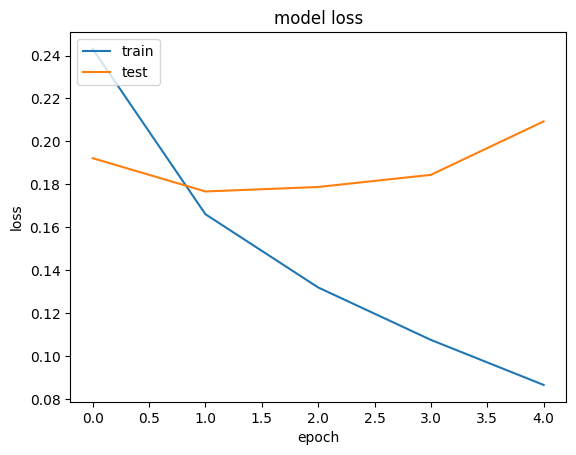

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
predicao = np.round(model.predict(X_test))

461/461 [==============================] - 1s 3ms/step


In [53]:
acc = accuracy_score(y_test, predicao)

In [54]:
acc

0.9415319842455521

In [55]:
print(classification_report(y_test, predicao))

              precision    recall  f1-score   support

           0       0.81      0.47      0.59      1343
           1       0.95      0.99      0.97     13383

    accuracy                           0.94     14726
   macro avg       0.88      0.73      0.78     14726
weighted avg       0.94      0.94      0.93     14726



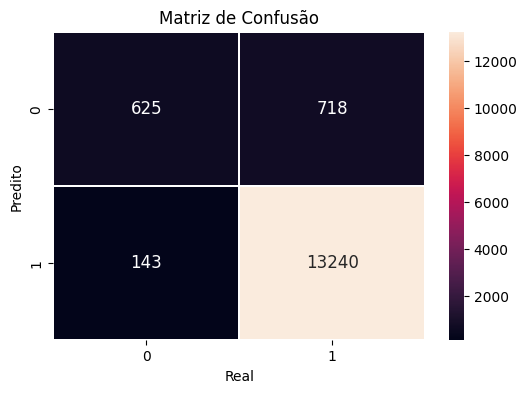

In [56]:
mc = confusion_matrix(y_test, predicao)
plt.figure(figsize=(6,4))
sbn.heatmap(mc, annot=True, linewidth=0.2, annot_kws={'size':12}, fmt='.0f')
plt.title("Matriz de Confusão", fontsize=12)
plt.xlabel('Real')
plt.ylabel('Predito')
plt.show()

In [72]:
# Carregando os pesos do treinamento anterior extensão .hdf5
def load_weights_from_hdf5(model, weight_path):
    model.load_weights(weight_path)
    return model

In [73]:
# Declarando arquitetura da rede novamente
model = Sequential()
model.add(Embedding(input_dim=MAX_WORDS,output_dim=EMBED_DIM, input_length=INPUT_LENGTH, weights=[EMBEDDING_MATRIX]))
model.add(Flatten())
model.add(Dense(24, activation="relu"))
model.add(Dropout(0.05))
model.add(Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 808, 50)           800000    
                                                                 
 flatten_2 (Flatten)         (None, 40400)             0         
                                                                 
 dense_4 (Dense)             (None, 24)                969624    
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 1,769,649
Trainable params: 1,769,649
Non-trainable params: 0
_________________________________________________________________


In [75]:
# Acoplando os pesos ao modelo
hdf5_weight_path = '../weights/glove_tl_weights.hdf5'
model = load_weights_from_hdf5(model, hdf5_weight_path)

In [89]:
OPTIMIZER_TRAINABLE = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
OPTIMIZER_TRAINABLE.build(model.trainable_variables)

# Recompilando o modelo depois do carregamento dos pesos
model.compile(optimizer=OPTIMIZER_TRAINABLE, loss=LOSS, metrics=METRICS)

In [90]:
# Continuando o treinamento com fine-tuning
model_history_fine_tuning = model.fit(
    X_train, 
    y_train, 
    verbose=1, 
    batch_size=BATCH_SIZE,  
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=CALLBACKS
)

Epoch 1/10
1839/1841 [============================>.] - ETA: 0s - loss: 0.0077 - acc: 0.9981
Epoch 1: val_loss did not improve from 0.17669
1841/1841 [==============================] - 39s 21ms/step - loss: 0.0077 - acc: 0.9981 - val_loss: 0.6892 - val_acc: 0.9282
Epoch 2/10
1840/1841 [============================>.] - ETA: 0s - loss: 0.0076 - acc: 0.9981
Epoch 2: val_loss did not improve from 0.17669
1841/1841 [==============================] - 38s 21ms/step - loss: 0.0076 - acc: 0.9981 - val_loss: 0.7436 - val_acc: 0.9336
Epoch 3/10
1840/1841 [============================>.] - ETA: 0s - loss: 0.0067 - acc: 0.9982
Epoch 3: val_loss did not improve from 0.17669
1841/1841 [==============================] - 38s 21ms/step - loss: 0.0067 - acc: 0.9982 - val_loss: 0.7962 - val_acc: 0.9354
Epoch 4/10
1839/1841 [============================>.] - ETA: 0s - loss: 0.0068 - acc: 0.9981
Epoch 4: val_loss did not improve from 0.17669
1841/1841 [==============================] - 38s 21ms/step - loss

In [91]:
NB_START_EPOCHS_FINE_TUNING = 4

In [92]:
def eval_metric(history, metric_name):
    '''
    Função para avaliar o modelo treinado na métrica escolhida. 
    Treino e valição são plotados por época.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS_FINE_TUNING + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

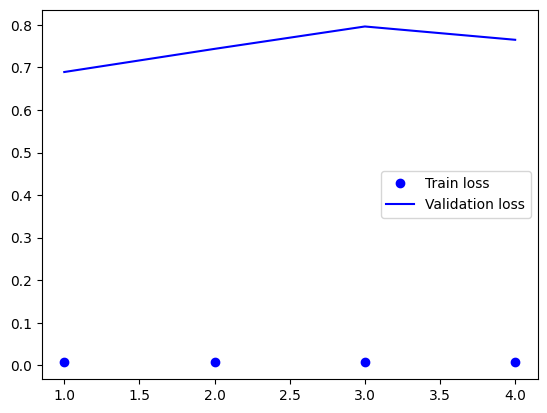

In [94]:
eval_metric(model_history_fine_tuning, 'loss')

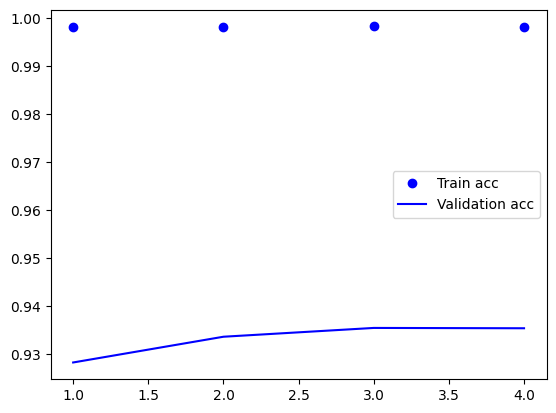

In [95]:
eval_metric(model_history_fine_tuning, 'acc')

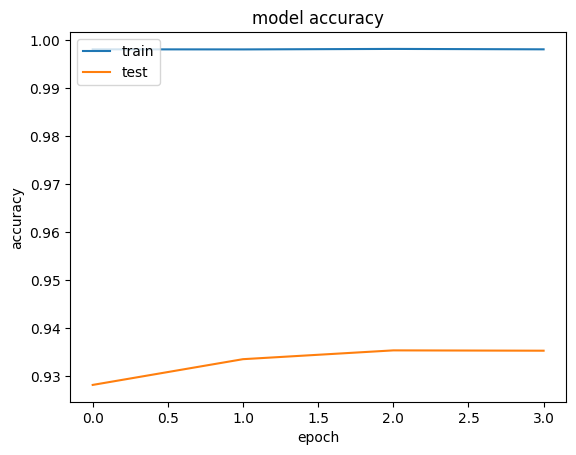

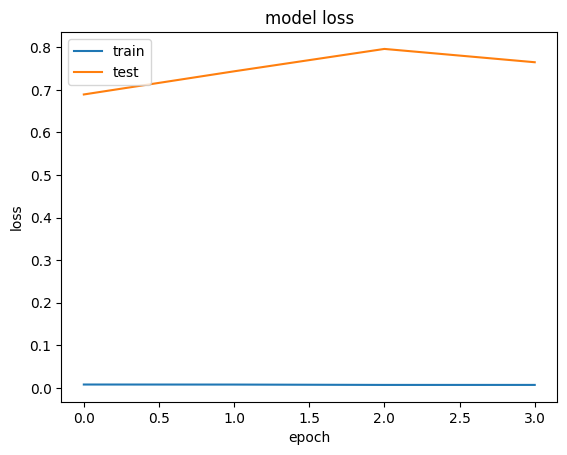

In [96]:
plt.plot(model_history_fine_tuning.history['acc'])
plt.plot(model_history_fine_tuning.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model_history_fine_tuning.history['loss'])
plt.plot(model_history_fine_tuning.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [97]:
predicao_fine_tuning = np.round(model.predict(X_test))

461/461 [==============================] - 1s 3ms/step


In [98]:
acc_fine_tuning = accuracy_score(y_test, predicao_fine_tuning)

In [99]:
acc_fine_tuning

0.9353524378650007

In [100]:
print(classification_report(y_test, predicao_fine_tuning))

              precision    recall  f1-score   support

           0       0.68      0.56      0.61      1343
           1       0.96      0.97      0.96     13383

    accuracy                           0.94     14726
   macro avg       0.82      0.77      0.79     14726
weighted avg       0.93      0.94      0.93     14726

